In [1]:
import matplotlib
matplotlib.use('nbagg') #matplotlib1.4で新たに追加された機能。jupyter上でインタラクティブな画像表示を実現するため。
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [2]:
class World:
    def __init__(self,time_span,time_interval,debug=False):#世界座標系を作る前に、必要な変数を宣言。
        self.objects = [] #主に、IdealRobotを入れる空リストを生成
        self.debug = debug
        self.time_span = time_span #合計時間(s)
        self.time_interval = time_interval #1フレーム間の時間(s)
        
    def append(self,obj):#物体を追加する。

        self.objects.append(obj)

    def draw(self): #グラフの準備
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect("equal")
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)
        ax.set_xlabel("X",fontsize=10)
        ax.set_ylabel("Y",fontsize=10)
        
        elems=[]#サブプロットのaxを全てelems内で作る。時刻が変わるたびに、elemsをリセットすることで、サブプロットをリセットできる。
                #サブプロットを記述していたら、1つひとつを消すのが面倒。（できないのかも？）ax.plot(~~)  --->  elems += ax.plot(~~)
        if self.debug:
            print("Hello")
            for i in range(1000): self.one_step(i, elems, ax)
        else:
            #FuncAnimationは、関数を実行しながらアニメーションを作成する。https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=int(self.time_span/self.time_interval)+1,
                                         interval=int(self.time_interval*1000), repeat=False)
            plt.show()
            self.ani.save("c04.gif", writer="imagemagick")

    def one_step(self, i, elems, ax):#ある時刻の姿勢と時刻の文字列を座標系に追加するメソッド。
        while elems:elems.pop().remove()
        time_str = "t=%.2f[s]"%(self.time_interval*i)
        elems.append(ax.text(-4.4,4.5,time_str, fontsize=10)) #次の、axに記入する文字をelemsに加える。
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj,"one_step"):obj.one_step(self.time_interval) #objがidealrobotクラスの場合、次の姿勢が決まる。

In [3]:
class IdealRobot:
    def __init__(self, pose, agent=None, sensor=None, color="black"):
        self.pose = pose
        self.r = 0.2
        self.color =color
        self.agent =agent
        self.poses = [pose]
        self.sensor = sensor
    
    def draw(self,ax,elems):#現在の姿勢と、前の時刻から進んだロボットの軌跡をaxに追加し、elemsにも追加。
        x, y, theta = self.pose
        xn = x + self.r * math.cos(theta)
        yn = y + self.r * math.sin(theta)
        elems += ax.plot([x,xn],[y,yn],color=self.color)
        c = patches.Circle(xy=(x,y),radius=self.r,fill=False,color=self.color)
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        if self.sensor and len(self.poses) > 1:
            self.sensor.draw(ax, elems, self.poses[-2])

    @classmethod
    def state_transition(cls,nu,omega,time,pose):
        t0 =pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array([nu*math.cos(t0),nu*math.sin(t0),omega])*time
        else:
            return pose+np.array([nu/omega*(math.sin(t0+omega*time)-math.sin(t0)),nu/omega*(-math.cos(t0+omega*time)+math.cos(t0)),omega*time])
    def one_step(self, time_interval):#次の姿勢を計算して、self.poseに入れるメソッド。
        if not self.agent: return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        self.pose = self.state_transition(nu,omega,time_interval,self.pose)

In [4]:
class Agent:
    def __init__(self,nu,omega):
        self.nu =nu
        self.omega = omega
    def decision(self,observation=None):
        return self.nu, self.omega

In [5]:
class Landmark:
        def __init__(self,x,y):
            self.pos = np.array([x,y]).T
            self.id = None
        
        def draw(self,ax,elems):
            c = ax.scatter(self.pos[0],self.pos[1],s=100,marker="*",label="landmarks",color="orange")
            elems.append(c)
            elems.append(ax.text(self.pos[0],self.pos[1],"id:"+str(self.id),fontsize=10))
            
class Map:
        def __init__(self):
            self.landmarks = []

        def append_landmark(self, landmark):
            landmark.id = len(self.landmarks)
            self.landmarks.append(landmark)
        
        def draw(self,ax,elems):
            for lm in self.landmarks:
                lm.draw(ax,elems)

class IdealCamera:
    def __init__(self,env_map):
        self.map = env_map
        self.lastdata = []
        
    def data(self,cam_pose):
        observed = []
        for lm in self.map.landmarks:
            p = self.observation_function(cam_pose, lm.pos)
            observed.append((p,lm.id))
        self.lastdata = observed
        return observed #センサ値とランドマークのIDをtupleでセットにして順に入れるリスト
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1],diff[0])-cam_pose[2]
        while phi >= np.pi: phi -=2*np.pi
        while phi < -np.pi:phi +=2*np.pi
        return np.array([np.hypot(*diff),phi]).T
    
    def draw(self,ax,elems,cam_pose):
        for lm in self.lastdata:
            x,y,theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance*math.cos(direction+theta)
            ly = y + distance*math.sin(direction+theta)
            elems += ax.plot([x,lx], [y,ly], color="pink")

<IPython.core.display.Javascript object>


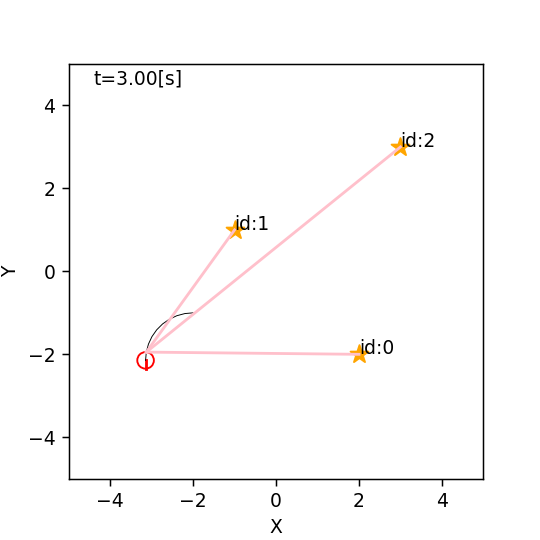

MovieWriter imagemagick unavailable; using Pillow instead.


[(array([4.91345448, 2.14842284]), 0), (array([ 3.05468702, -3.10551058]), 1), (array([7.34785901, 2.91253459]), 2)]


In [8]:
world = World(3,1,debug=0)

m = Map()
m.append_landmark(Landmark(2,-2))
m.append_landmark(Landmark(-1,1))
m.append_landmark(Landmark(3,3))
world.append(m)

#straight = Agent(0.2,0.0)#進み方1を作成。
circling = Agent(0.2,10.0/180*math.pi)#進み方2を作成。
#robot1=IdealRobot(np.array([2,3,math.pi/6]).T,sensor=IdealCamera(m), agent=straight)           #座標(2,3)でmath.pi/6方向で始まり、進み方1で制御されるロボットを作成。
robot2=IdealRobot(np.array([-2,-1,math.pi]).T,sensor=IdealCamera(m), agent=circling,color="red")#座標(-2,-1)にmath.pi方向で始まり、進み方2で制御されるロボットを作成。

#print("test",robot1.pose)
#print("test",robot1.sensor)

#world.append(robot1)
world.append(robot2)

world.draw()
cam = IdealCamera(m)
p = cam.data(robot2.pose)
print(p)